This notebook is thought to be executed in Google colab, but ignoring this first cell can be executed in any jupyter environment.

In [1]:
!pip install -U -q PyDrive
!apt-get install -y libhdf5-serial-dev
!pip install tables

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import os

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

local_download_path = os.path.expanduser('~/data')
try:
  os.makedirs(local_download_path)
except: pass


file_list = drive.ListFile(
    {'q': "'your_folder_drive_id' in parents"}).GetList()

for f in file_list:
  print('title: %s, id: %s' % (f['title'], f['id']))
  fname = os.path.join(local_download_path, f['title'])
  print('downloading to {}'.format(fname))
  f_ = drive.CreateFile({'id': f['id']})
  f_.GetContentFile(fname)


Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  libhdf5-serial-dev
0 upgraded, 1 newly installed, 0 to remove and 12 not upgraded.
Need to get 2,898 B of archives.
After this operation, 37.9 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libhdf5-serial-dev all 1.10.0-patch1+docs-4 [2,898 B]
Fetched 2,898 B in 0s (30.6 kB/s)
Selecting previously unselected package libhdf5-serial-dev.
(Reading database ... 22278 files and directories currently installed.)
Preparing to unpack .../libhdf5-serial-dev_1.10.0-patch1+docs-4_all.deb ...
Unpacking libhdf5-serial-dev (1.10.0-patch1+docs-4) ...
Setting up libhdf5-serial-dev (1.10.0-patch1+docs-4) ...
    100% |████████████████████████████████| 3.8MB 10.2MB/s 
    100% |████████████████████████████████| 163kB 30.5MB/s 
title: oo_data_region.hdf, id: 17FXh20y_J2TOyntDT4BezRXP3ZmDtKVR
downloading to /

In [2]:
 
import pandas as pd
import seaborn as sns
import numpy as np
import warnings
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm
warnings.filterwarnings('ignore')
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
from sklearn import linear_model
from sklearn.preprocessing import Imputer
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from keras.layers.core import Dense
from keras.layers.recurrent import LSTM
from keras.layers import Dense, Dropout, Activation, Flatten,Reshape
from keras.layers import LSTM, LeakyReLU, CuDNNLSTM
from keras.models import Sequential
from keras import backend
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, r2_score
from sklearn import svm
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Conv1D, MaxPooling1D, LeakyReLU
from keras import regularizers
from keras import metrics
%matplotlib inline

Using TensorFlow backend.


In [0]:
mape = lambda y_actual, y_predicted: np.mean(np.abs((y_actual - y_predicted) / y_actual)) * 100


def display_predicted_prices(predictions, real, prices_last):
    predictions_price = prices_last + (prices_last * predictions)
    true_price = prices_last + (prices_last * real)
    cumret = (predictions * real).cumsum()

    plt.plot(predictions, label='Predicted')
    plt.plot(real, label='Real')
    plt.legend()
    plt.show()

    plt.plot(predictions_price, label='Predicted price')
    plt.plot(true_price, label='Real price')
    plt.legend()
    plt.show()
    
    plt.plot(cumret, label='Cummulative return')
    plt.legend()
    plt.show()
    
    print("MAPE", mape(true_price, predictions_price))
    print("MSE", mean_squared_error(true_price, predictions_price))
    print("Accuracy", accuracy_score(np.sign(real), np.sign(predictions)))

In [0]:
def display_predicted(predictions, real, X_test):
    increases_prediction = predictions > X_test['price-1w']
    increases_real = real > X_test['price-1w']
    print("MAPE", mape(real, predictions))
    print("MSE", mean_squared_error(real, predictions))
    print("Accuracy", accuracy_score(increases_real, increases_prediction))

    plt.plot(predictions, label='Predicted price')
    plt.plot(real, label='Real price')
    plt.legend()
    plt.show()

In [0]:
def display_predicted_prices_multiple(predictions, real, prices_last, y_weeks_nr):
    df = pd.DataFrame()
    predictions_price = prices_last + (prices_last * predictions)
    true_price = prices_last + (prices_last * real)
    df['predictions_price'] = predictions_price
    df['true_price'] = true_price
    df['predictions'] = predictions
    df['real'] = real
    df['week_nr'] = y_weeks_nr
    df = df.groupby('week_nr')['predictions_price', 'true_price', 'predictions', 'real'].mean()
    print("MAPE", mape(true_price, predictions_price))
    print("MSE", mean_squared_error(true_price, predictions_price))
    print("Accuracy", accuracy_score(np.sign(real), np.sign(predictions)))
    plt.plot(df['predictions'], label='Predicted')
    plt.plot(df['real'], label='Real')
    plt.legend()
    plt.show()

    plt.plot(df['predictions_price'], label='Predicted price')
    plt.plot(df['true_price'], label='Real price')
    plt.legend()
    plt.show()

Here, I will keep two datasets, one with all provinces and another one without it

In [0]:
oo_df = pd.read_hdf('/root/data/oo_data_region.hdf', 'data')
oo_jaen_df = oo_df[oo_df['provincia'] == 'JAEN']
provincia_encoder = preprocessing.LabelEncoder()
oo_df['provincia'] = provincia_encoder.fit_transform(oo_df['provincia'])

In [0]:
def create_dataset(test_size, include_columns=None, df=oo_df, test_column='price_perc'):

    train_df = df[:-test_size].reset_index(drop=True)
    test_df = df[-test_size:].reset_index(drop=True)
    
    y_train = train_df[test_column]
    X_train = train_df[include_columns]
    y_test = test_df[test_column]
    y_last_prices = test_df['price-1w']
    X_test = test_df[include_columns]
    return X_train, y_train, X_test, y_test, y_last_prices

In [8]:
oo_df.columns

Index(['price', 'provincia', 'price-1w', 'price-2w', 'price-4w', 'price+3w',
       'price-6w', 'price-8w', 'price-4w_mean', 'price-8w_mean', 'price_perc',
       'price_perc_medium', 'price_perc-2w', 'price_perc-4w', 'price_perc-6w',
       'price_perc-8w', 'tmin', 'tmax', 'tmed', 'prec', 'racha', 'week_nr',
       'prec-4w_sum', 'prec-13w_sum', 'prec-26w_sum', 'prec-52w_sum',
       'tmed-4w_mean', 'prec-4w_sum_perc', 'prec-13w_sum_perc',
       'prec-26w_sum_perc', 'prec-52w_sum_perc', 'tmed-4w_mean_perc',
       'tmin_perc', 'tmax_perc', 'tmed_perc', 'prec_perc', 'freeze_damage',
       'month', 'production_tons-1m_sum', 'production_tons-3m_sum',
       'production_tons-6m_sum', 'production_tons-9m_sum',
       'production_tons-12m_sum', 'production_tons-1m_sum_perc',
       'production_tons-3m_sum_perc', 'production_tons-6m_sum_perc',
       'production_tons-9m_sum_perc', 'production_tons-12m_sum_perc'],
      dtype='object')

In [0]:
X_train, y_train, X_test, y_test, y_last_prices = create_dataset(52, df=oo_jaen_df, include_columns=['price_perc-2w', 'price_perc-4w', 
                          'production_tons-1m_sum', 'production_tons-12m_sum', 'prec-52w_sum', 'freeze_damage', 'week_nr'
                         ])

Let's scale the data, the model works better with 0-1 inputs

In [0]:
scaler = MinMaxScaler(feature_range=(0, 1))
output_scaler = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)
y_train_scaled = output_scaler.fit_transform(y_train.reshape(-1,1))
y_test_scaled = output_scaler.transform(y_test.reshape(-1,1))

Let's try the short term forecasting.

After several runs, the final architecture is the shown below, a 4 hidden layers architecture, using dropout.

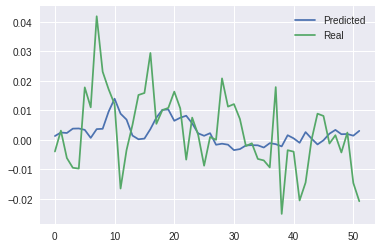

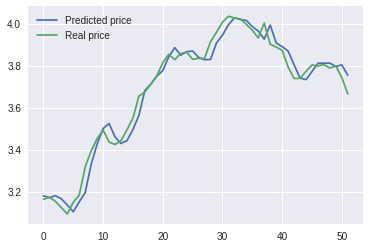

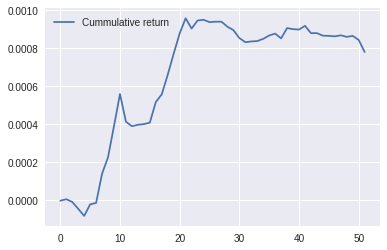

MAPE 0.981622621532455
MSE 0.0021830554768412606
Accuracy 0.5576923076923077


In [13]:
model = Sequential()
model.add(Dense(8, input_dim=X_train_scaled.shape[1], activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(8, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(4, activation='relu'))
model.add(Dense(1))
# Compile model
model.compile(optimizer ='adam', loss = 'mean_squared_error', metrics=[metrics.mae])
history = model.fit(X_train_scaled, y_train_scaled, validation_data=(X_test_scaled, y_test_scaled), epochs=100, batch_size=21, verbose=0)
predicted = model.predict(X_test_scaled)
predicted = output_scaler.inverse_transform(predicted)
predicted = np.reshape(predicted, (predicted.size,))
display_predicted_prices(predicted, y_test, y_last_prices)

Now, I'm going to test using LSTM neurons combined with dense layers and using dropout. Afer several architecture test, the best one was the shown below.

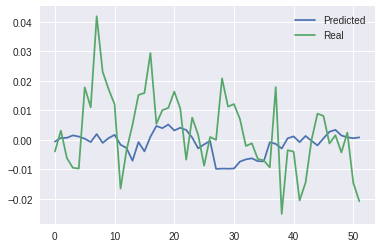

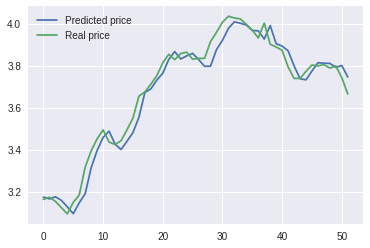

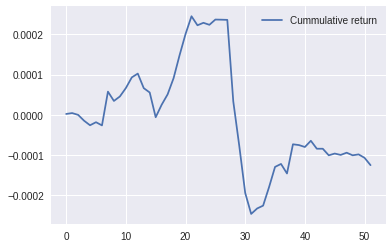

MAPE 1.1078256183517456
MSE 0.0026003083261291336
Accuracy 0.5


In [14]:
X_train, y_train, X_test, y_test, y_last_prices = create_dataset(52, df=oo_jaen_df, include_columns=[
    'price_perc-2w', 'price_perc-4w', 
    'production_tons-1m_sum', 'production_tons-12m_sum', 'prec-52w_sum', 'freeze_damage', 
    'week_nr'
])
scaler = MinMaxScaler(feature_range=(0, 1))
output_scaler = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler.fit_transform(X_train)
X_train_rs = np.reshape(X_train_scaled, (X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_scaled = scaler.fit_transform(X_test)
X_test_rs = np.reshape(X_test_scaled, (X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))
y_train_scaled = output_scaler.fit_transform(y_train.reshape(-1,1))
y_test_scaled = output_scaler.transform(y_test.reshape(-1,1))

model = Sequential()
model.add(LSTM(8, input_shape=(X_train_rs.shape[1], X_train_rs.shape[2]), return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(16, return_sequences=False))
model.add(Dense(8, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(4, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1))
# Compile model
model.compile(optimizer ='adam', loss = 'mean_squared_error', metrics=[metrics.mae])
history = model.fit(X_train_rs, y_train_scaled, validation_data=(X_test_rs, y_test_scaled), epochs=100, batch_size=32, verbose=0)
predicted = model.predict(X_test_rs)
predicted = output_scaler.inverse_transform(predicted)
predicted = np.reshape(predicted, (predicted.size,))
display_predicted_prices(predicted, y_test, y_last_prices)

Now, it is time to test the mid-term forecasting. I'll reuse the 4 hidden layers architecture.

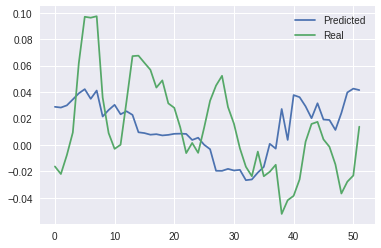

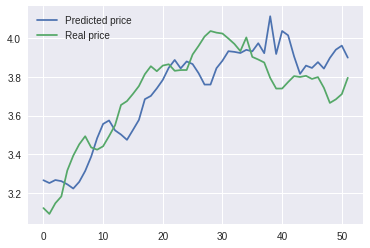

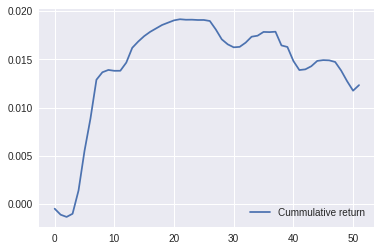

MAPE 3.3203046512233243
MSE 0.0214679912763619
Accuracy 0.5961538461538461


In [22]:
X_train, y_train, X_test, y_test, y_last_prices = create_dataset(52, df=oo_jaen_df, include_columns=[
    'price_perc-2w', 'price_perc-4w', 'price_perc-8w',
    'production_tons-1m_sum', 'production_tons-12m_sum', 
    'prec-52w_sum', 'freeze_damage', 
    'week_nr'
     ], test_column='price_perc_medium')

scaler = MinMaxScaler(feature_range=(0, 1))
output_scaler = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)
y_train_scaled = output_scaler.fit_transform(y_train.reshape(-1,1))
y_test_scaled = output_scaler.transform(y_test.reshape(-1,1))

model = Sequential()
model.add(Dense(8, input_dim=X_train_scaled.shape[1], activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(8, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(8, activation='relu'))
model.add(Dense(1))

model.compile(optimizer ='adam', loss = 'mean_squared_error', metrics=[metrics.mae])
history = model.fit(X_train_scaled, y_train_scaled, validation_data=(X_test_scaled, y_test_scaled), epochs=200, batch_size=21, verbose=0)
predicted = model.predict(X_test_scaled)
predicted = output_scaler.inverse_transform(predicted)
predicted = np.reshape(predicted, (predicted.size,))
display_predicted_prices(predicted, y_test, y_last_prices)